In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./mytorch')
from mytorch import Tensor
from mytorch.model import Model
from mytorch.layer import Linear
from mytorch.activation import relu, softmax
from mytorch.loss import CategoricalCrossEntropy 
from mytorch.optimizer import Adam

In [ ]:
# بخش آماده‌سازی داده‌ها
def prepare_data(filepath="diabetes.csv"):
    data = pd.read_csv(filepath)
    
    # لیست ستون‌هایی که نباید صفر باشند
    invalid_zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    
    # جایگزینی صفر با NaN و سپس پر کردن با میانه
    for col in invalid_zero_cols:
        data[col] = data[col].replace(0, np.nan)
        data[col] = data[col].fillna(data[col].median())
    
    # جداسازی ویژگی‌ها و برچسب
    target_col = "Outcome"
    features = data.drop(columns=[target_col]).values.astype(np.float64)
    labels = data[target_col].values.astype(int)
    
    # استانداردسازی دستی (Z-Score Normalization)
    # (x - mu) / sigma
    mu = np.mean(features, axis=0)
    sigma = np.std(features, axis=0) + 1e-8 # جلوگیری از تقسیم بر صفر
    features_norm = (features - mu) / sigma
    
    return features_norm, labels

In [7]:
# تعریف مدل شبکه عصبی
class PimaClassifier(Model):
    def __init__(self):
        super().__init__()
        # معماری شبکه: ورودی 8 -> لایه مخفی 32 -> لایه مخفی 16 -> خروجی 2 کلاس
        self.fc1 = Linear(8, 32, need_bias=True, mode="he")
        self.fc2 = Linear(32, 16, need_bias=True, mode="he")
        self.head = Linear(16, 2, need_bias=True, mode="xavier")
        
    def forward(self, x: Tensor):
        # انتشار رو به جلو
        out = relu(self.fc1(x))
        out = relu(self.fc2(out))
        logits = self.head(out)
        return logits
        
    def parameters(self):
        # بازگرداندن پارامترهای تمام لایه‌ها برای بهینه‌ساز
        return [self.fc1, self.fc2, self.head]

In [8]:
# توابع کمکی آموزش 
def calc_accuracy(model, x_numpy, y_numpy):
    """محاسبه دقت مدل روی یک دسته داده"""
    x_tensor = Tensor(x_numpy)
    # محاسبه خروجی مدل
    logits = model(x_tensor)
    # اعمال سافت‌مکس برای تبدیل به احتمال
    probs = softmax(logits).data
    # انتخاب کلاسی که بیشترین احتمال را دارد
    preds = np.argmax(probs, axis=1)
    
    correct = np.sum(preds == y_numpy)
    return correct / len(y_numpy)

def run_training_loop(model, x_train, y_train, x_val, y_val, config):
    """حلقه اصلی آموزش"""
    lr = config.get('lr', 0.001)
    epochs = config.get('epochs', 200)
    bs = config.get('batch_size', 32)
    
    optim = Adam(model.parameters(), learning_rate=lr)
    
    num_samples = len(x_train)
    history = {'loss': [], 'train_acc': [], 'val_acc': []}
    
    print(f"Starting training on {num_samples} samples for {epochs} epochs...")
    
    for ep in range(1, epochs + 1):
        # شافل کردن داده‌ها در هر ایپاک
        indices = np.random.permutation(num_samples)
        x_shuffled = x_train[indices]
        y_shuffled = y_train[indices]
        
        epoch_loss = 0
        correct_preds = 0
        batches = 0
        
        # پیمایش بچ‌ها
        for i in range(0, num_samples, bs):
            x_batch = Tensor(x_shuffled[i:i+bs], requires_grad=True)
            y_batch = Tensor(y_shuffled[i:i+bs])
            
            # Forward
            preds = model(x_batch)
            probs = softmax(preds)
            
            # محاسبه هزینه
            loss_val = CategoricalCrossEntropy(probs, y_batch)
            
            # Backward
            optim.zero_grad()
            loss_val.backward()
            optim.step()
            
            # آمارگیری
            epoch_loss += float(loss_val.data)
            
            # محاسبه دقت آموزش در حین اجرا
            cls_preds = np.argmax(probs.data, axis=1)
            correct_preds += np.sum(cls_preds == y_shuffled[i:i+bs])
            batches += 1
            
        # ثبت نتایج ایپاک
        avg_loss = epoch_loss / batches
        train_acc = correct_preds / num_samples
        
        history['loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        
        # اعتبارسنجی (Validation)
        val_acc = calc_accuracy(model, x_val, y_val)
        history['val_acc'].append((ep, val_acc))
        
        # چاپ وضعیت (هر 10 دور)
        if ep % 10 == 0 or ep == 1:
            print(f"[Epoch {ep:03d}] Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")
            
    return history

In [9]:
def show_results(history, final_acc):
    """رسم نمودارهای مربوط به آموزش"""
    plt.figure(figsize=(14, 5))
    
    # نمودار Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss', color='tab:orange')
    plt.title('Learning Curve (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # نمودار دقت
    plt.subplot(1, 2, 2)
    val_epochs, val_accs = zip(*history['val_acc'])
    plt.plot(history['train_acc'], label='Training Accuracy', color='tab:blue')
    plt.plot(val_epochs, val_accs, label='Validation Accuracy', color='tab:green', linestyle='--')
    plt.axhline(y=0.60, color='red', linestyle=':', label='Goal (60%)')
    
    plt.title(f'Accuracy Evolution (Final Test: {final_acc:.2%})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.4)
    
    plt.tight_layout()
    plt.show()

def print_confusion_matrix(y_true, y_pred):
    """نمایش ماتریس درهم‌ریختگی به صورت متنی"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    print("\n--- Confusion Matrix ---")
    print(f"                Predicted 0   Predicted 1")
    print(f"Actual 0 (No)      {tn:<5}         {fp:<5}")
    print(f"Actual 1 (Yes)     {fn:<5}         {tp:<5}")
    print("------------------------")

Data Loaded: 768 samples.
Training set: (614, 8), Test set: (154, 8)

Starting training on 614 samples for 200 epochs...
[Epoch 001] Loss: 0.7172 | Train Acc: 54.56% | Val Acc: 61.69%
[Epoch 010] Loss: 0.4515 | Train Acc: 79.80% | Val Acc: 74.68%
[Epoch 020] Loss: 0.4093 | Train Acc: 81.60% | Val Acc: 75.97%
[Epoch 030] Loss: 0.4013 | Train Acc: 80.62% | Val Acc: 76.62%
[Epoch 040] Loss: 0.3829 | Train Acc: 82.08% | Val Acc: 77.92%
[Epoch 050] Loss: 0.3805 | Train Acc: 83.06% | Val Acc: 77.27%
[Epoch 060] Loss: 0.3566 | Train Acc: 83.22% | Val Acc: 79.22%
[Epoch 070] Loss: 0.3287 | Train Acc: 84.85% | Val Acc: 78.57%
[Epoch 080] Loss: 0.3157 | Train Acc: 85.34% | Val Acc: 77.27%
[Epoch 090] Loss: 0.2993 | Train Acc: 86.32% | Val Acc: 77.92%
[Epoch 100] Loss: 0.2989 | Train Acc: 87.13% | Val Acc: 76.62%
[Epoch 110] Loss: 0.2663 | Train Acc: 88.11% | Val Acc: 76.62%
[Epoch 120] Loss: 0.2712 | Train Acc: 88.44% | Val Acc: 77.92%
[Epoch 130] Loss: 0.2473 | Train Acc: 89.74% | Val Acc: 77.9

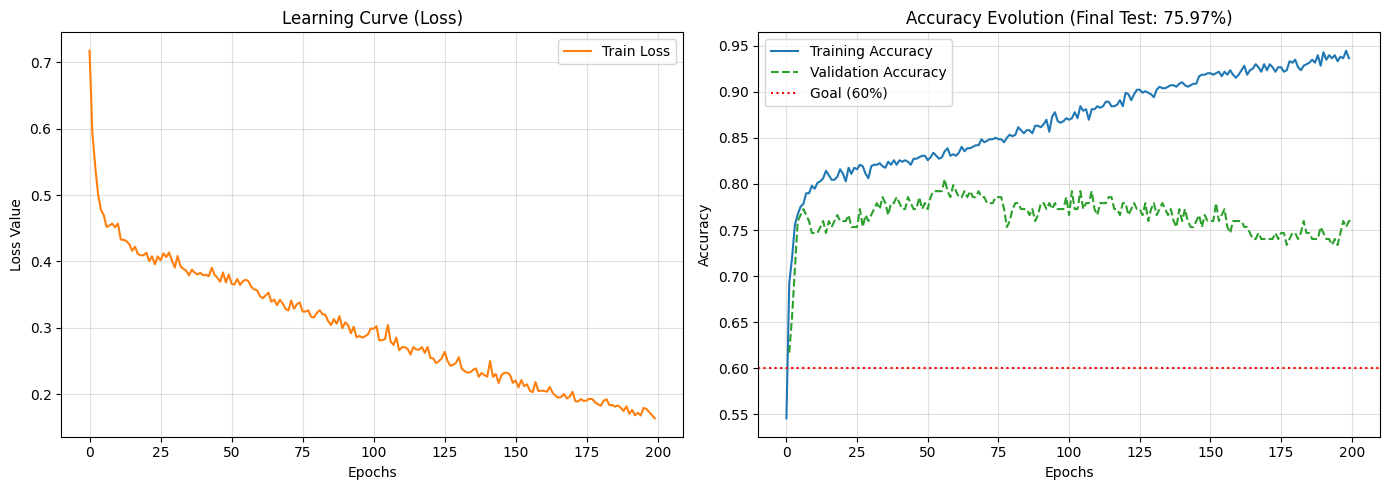

In [10]:
# بدنه اصلی برنامه
if __name__ == "__main__":
    # تنظیمات
    CONFIG = {
        'lr': 0.001,
        'epochs': 200,
        'batch_size': 32
    }
    
    # 1. دریافت داده
    X, y = prepare_data("diabetes.csv")
    
    # تقسیم داده‌ها (80% آموزش - 20% تست)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Data Loaded: {len(X)} samples.")
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}\n")
    
    # 2. ساخت مدل
    net = PimaClassifier()
    
    # 3. شروع آموزش
    hist = run_training_loop(net, X_train, y_train, X_test, y_test, CONFIG)
    
    # 4. ارزیابی نهایی
    print("\nEvaluating Final Model...")
    # محاسبه پیش‌بینی‌های نهایی
    logits = net(Tensor(X_test))
    final_probs = softmax(logits).data
    final_preds = np.argmax(final_probs, axis=1)
    
    final_acc = np.mean(final_preds == y_test)
    
    print(f"Final Test Accuracy: {final_acc:.4f}")
    
    if final_acc >= 0.60:
        print(">> Success: Model passed the required threshold (60%).")
    else:
        print(">> Warning: Model accuracy is below 60%. Consider tuning hyperparameters.")
        
    print_confusion_matrix(y_test, final_preds)
    
    # 5. رسم نمودار
    show_results(hist, final_acc)